# Redes Neuronales Recurrentes

Redes neuronales recurrentes (RNN): Las RNN son efectivas para trabajar con datos secuenciales, como series de tiempo o lenguaje natural. Variaciones de RNN, como las unidades recurrentes de memoria a largo plazo (LSTM) y las redes neuronales recurrentes compuertas (GRU), son comúnmente utilizadas.

In [1]:
# Importamos las librerías

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

2023-06-07 00:57:04.334412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cargar los datos
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataframe = pd.read_csv(url, usecols=[1])

dataframe.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


También necesitamos normalizar los datos. Las redes neuronales a menudo funcionan mejor con la entrada normalizada, es decir, los datos que se han escalado para tener un rango entre 0 y 1.

In [4]:
# Convertir a float32
data = dataframe.values.astype("float32")

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

print("Datos de entrenamiento: ", len(train))
print("Datos de prueba: ", len(test))

Datos de entrenamiento:  96
Datos de prueba:  48


Una vez que tenemos nuestros datos de entrenamiento y prueba listos, necesitamos prepararlos para el formato que la red neuronal recurrente espera, que es [muestras, pasos de tiempo, características].

En este caso, vamos a utilizar una ventana de tiempo de 1, es decir, vamos a utilizar el número de pasajeros del mes anterior para predecir el número de pasajeros del mes actual.

In [5]:
# Función para crear un dataset

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# remodelar la entrada para que sea [muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Este código crea un conjunto de datos donde Y es el número de pasajeros en el mes actual y X es el número de pasajeros en el mes anterior.

Construir nuestra Red Neuronal Recurrente. Vamos a usar la biblioteca Keras para construir una Red Neuronal Recurrente con capas LSTM (Long Short-Term Memory). Las capas LSTM son una especie de RNN que son capaces de aprender dependencias a largo plazo, lo que las hace muy adecuadas para este tipo de problema de series temporales.

In [6]:
# Crear y ajustar el modelo de la Red Neuronal Recurrente

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

Creamos un modelo con una capa LSTM con 4 unidades, seguida por una capa densa con 1 unidad (la salida). El modelo se compila con la pérdida del error cuadrático medio y el optimizador Adam.

In [7]:
# Entrenar el modelo

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 1s - loss: 0.1576 - 938ms/epoch - 10ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0948 - 71ms/epoch - 753us/step
Epoch 3/100
94/94 - 0s - loss: 0.0615 - 72ms/epoch - 766us/step
Epoch 4/100
94/94 - 0s - loss: 0.0474 - 70ms/epoch - 750us/step
Epoch 5/100
94/94 - 0s - loss: 0.0417 - 74ms/epoch - 791us/step
Epoch 6/100
94/94 - 0s - loss: 0.0385 - 69ms/epoch - 738us/step
Epoch 7/100
94/94 - 0s - loss: 0.0357 - 72ms/epoch - 762us/step
Epoch 8/100
94/94 - 0s - loss: 0.0331 - 71ms/epoch - 756us/step
Epoch 9/100
94/94 - 0s - loss: 0.0305 - 71ms/epoch - 756us/step
Epoch 10/100
94/94 - 0s - loss: 0.0281 - 69ms/epoch - 737us/step
Epoch 11/100
94/94 - 0s - loss: 0.0256 - 69ms/epoch - 730us/step
Epoch 12/100
94/94 - 0s - loss: 0.0230 - 68ms/epoch - 726us/step
Epoch 13/100
94/94 - 0s - loss: 0.0206 - 68ms/epoch - 721us/step
Epoch 14/100
94/94 - 0s - loss: 0.0186 - 67ms/epoch - 716us/step
Epoch 15/100
94/94 - 0s - loss: 0.0163 - 68ms/epoch - 728us/step
Epoch 16/100
94/94 - 0s - loss: 0.

Este código entrena el modelo durante 100 épocas con un tamaño de lote de 1.

Después de entrenar nuestro modelo, el siguiente paso sería utilizarlo para hacer predicciones. Vamos a hacer predicciones tanto para el conjunto de entrenamiento como para el conjunto de prueba para ver qué tan bien nuestro modelo está funcionando.

In [8]:
# Hacer predicciones

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 1ms/step


Después de hacer las predicciones, deberíamos invertir las transformaciones que hicimos al principio para que los resultados sean más interpretables. Para hacerlo, podemos usar la función inverse_transform que viene con el objeto MinMaxScaler que creamos al principio.

In [9]:
# Invertir las predicciones

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Finalmente, deberíamos calcular el error de raíz cuadrada medio (RMSE) para nuestras predicciones en los conjuntos de entrenamiento y prueba. Esto nos dará una medida cuantitativa de qué tan bien nuestro modelo está funcionando.

In [10]:
# Calcular el error cuadrático medio

from sklearn.metrics import mean_squared_error

trainScore = mean_squared_error(trainY[0], trainPredict[:, 0], squared=False)
print("Resultado del conjunto de entrenamiento: %.2f RMSE" % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:, 0], squared=False)
print("Resultado del conjunto de prueba: %.2f RMSE" % (testScore))

Resultado del conjunto de entrenamiento: 22.60 RMSE
Resultado del conjunto de prueba: 59.47 RMSE


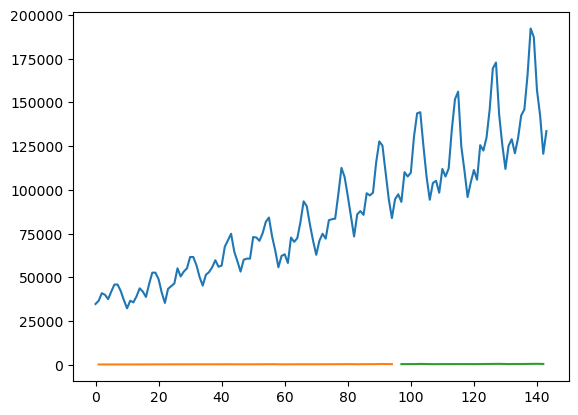

In [17]:
# Graficar los resultados

import matplotlib.pyplot as plt

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Este script realiza los siguientes pasos:

Crea dos nuevas series de tiempo vacías que tienen la misma longitud y forma que nuestro conjunto de datos original.

Inserta nuestras predicciones de entrenamiento y prueba en estas nuevas series de tiempo en los lugares correspondientes. Se inserta un valor "NaN" en los lugares donde no hicimos una predicción.

Trazar la serie de tiempo original y nuestras predicciones en el mismo gráfico.